# Convergence of cG(r)-cG(r) all-at-once scheme for exponential growth and harmonic oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.sparse import dok_matrix
from scipy.sparse.linalg import spsolve

In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Solve the exponential growth ODE with all-at-once cG(r)-cG(r) in FEniCS

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
--------------
|   r = 6   |
--------------
Final time error
Slope for cG(1)-cG(1): 1.9694630855293886
(1.0,1.2817181715409576)(0.5,0.13933446003799155)(0.25,0.03825930804992339)(0.125,0.009805213821675096)(0.0625,0.002466792079113933)(0.03125,0.0006176735538860889)(0.015625,0.000154479477417091)(0.0078125,3.862368925489079e-05)
Slope for cG(2)-cG(2): 1.9958163742706923
(1.0,0.0819181920954084)(0.5,0.02152057881731473)(0.25,0.005450594561538402)(0.125,0.001367142282992173)(0.0625,0.0003420678647310105)(0.03125,8.553463240890125e-05)(0.015625,2.13847626615582e-05)(0.0078125,5.346263759253844e-06)
Slope for cG(3)-cG(3): 3.9934847273642156
(1.0,0.005856102575434452)(0.5,0.0002084291382704606)(0.25,1.3378011579856519e-05)(0.125,8.417673185157071e-07)(0.0625,5.26989269999944

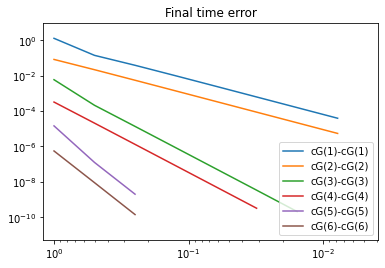

L2-norm error
Slope for cG(1)-cG(1): 2.136330146024259
(1.0,0.8706030906819471)(0.5,0.098855874416405)(0.25,0.027160372651062598)(0.125,0.006961616665672667)(0.0625,0.0017514534344348928)(0.03125,0.00043855924768410347)(0.015625,0.00010968338863083587)(0.0078125,2.742357201081571e-05)
Slope for cG(2)-cG(2): 1.9858249349766162
(1.0,0.054421162724982396)(0.5,0.014316053301777567)(0.25,0.003627116809617876)(0.125,0.0009098474199727456)(0.0625,0.000227654601218612)(0.03125,5.6925712568369925e-05)(0.015625,1.4232182326072956e-05)(0.0078125,3.558096441888087e-06)
Slope for cG(3)-cG(3): 4.1186858134834985
(1.0,0.0038885899375040904)(0.5,0.00014412391930475175)(0.25,9.257645720830063e-06)(0.125,5.826188313203623e-07)(0.0625,3.647674922036326e-08)(0.03125,2.2810335544079754e-09)(0.015625,1.4148301712489118e-10)
Slope for cG(4)-cG(4): 3.9910312450617464
(1.0,0.00021079794428843454)(0.5,1.3524968312421695e-05)(0.25,8.508986519109821e-07)(0.125,5.326892259111818e-08)(0.0625,3.330721257152112e-09)(

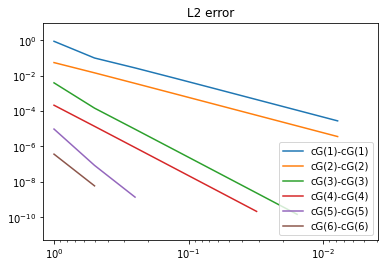

In [3]:
from fenics import *
import matplotlib.pyplot as plt
import math

set_log_active(False) # turn off FEniCS logging

# define temporal mesh
t0 = 0. # start time
T = 1. # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(8)]:
        mesh = IntervalMesh(n_time, t0, T)
        V = FunctionSpace(mesh, 'P', r)

        # Analytical solution U is used as Dirichlet BC
        U = Expression('exp(x[0])', degree=2*r+3)
        initial_time = "near(x[0], 0) && on_boundary"
        ic = DirichletBC(V, Constant(1.), initial_time)

        # Define variational problem
        f = Constant(0.)
        u = TrialFunction(V)
        v = TestFunction(V)
        a = grad(u)[0]*v*dx - u*v*dx
        L = f*v*dx

        # Solve
        u_k = Function(V)
        solve(a == L, u_k, ic)

        k = (T - t0) / n_time
        error["final"][r].append([k, np.abs(U(1.) - u_k(1.))])
        error["L2"][r].append([k, errornorm(U, u_k, 'L2')])
        
print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
        for _k, _e in zip(k_vals, err_vals):
            print(f"({_k},{_e})",end="")
        print("")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
        for _k, _e in zip(k_vals, err_vals):
            print(f"({_k},{_e})",end="")
        print("")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

#print(error["L2"][1])
#print(error["L2"][2])

## Solve the simple harmonic oscillator ODE with all-at-once cG(r)-cG(r) in FEniCS

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
--------------
|   r = 6   |
--------------
L2-norm error
Slope for cG(1)-cG(1): 1.872255422510075
(6.283185307179586,2.977768482291526)(3.141592653589793,2.27878978063004)(1.5707963267948966,1.361613769881446)(0.7853981633974483,0.26338913676624276)(0.39269908169872414,0.06177665105491097)(0.19634954084936207,0.015212597990529571)(0.09817477042468103,0.0037890839687602595)(0.04908738521234052,0.0009463984336794736)
Slope for cG(2)-cG(2): 2.0937978908092028
(6.283185307179586,2.240839329822586)(3.141592653589793,0.6679155669379303)(1.5707963267948966,0.12322846859082259)(0.7853981633974483,0.028868192256989566)(0.39269908169872414,0.007102201460083603)(0.19634954084936207,0.001768497819092124)(0.09817477042468103,0.0004416858060313965)(0.04908738521234052,0.000110394070

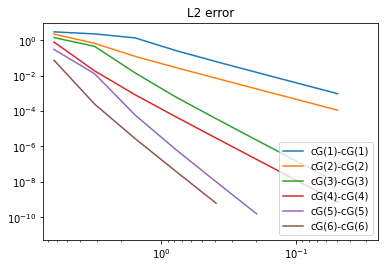

In [4]:
# define temporal mesh
t0 = 0. # start time
T = 2. * np.pi # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(8)]:
        mesh = IntervalMesh(n_time, t0, T)
        element = {
            "u": VectorElement("Lagrange", mesh.ufl_cell(), r),
            "v": FiniteElement("Lagrange", mesh.ufl_cell(), r),
        }
        V = FunctionSpace(mesh, MixedElement(*element.values()))

        # Analytical solution U is used as Dirichlet BC
        U_analytical = Expression(('sin(x[0])', 'cos(x[0])'), degree=2*r+3)
        initial_time = "near(x[0], 0) && on_boundary"
        ic = DirichletBC(V, Constant((0., 1.)), initial_time)

        # Define variational problem
        f_u = Constant(0.)
        f_v = Constant(0.)
        U = TrialFunction(V)
        Phi = TestFunction(V)
                          
        #print(shape(grad(u)))
        a_u = U[1].dx(0)*Phi[0]*dx + U[0]*Phi[0]*dx
        a_v = U[0].dx(0)*Phi[1]*dx - U[1]*Phi[1]*dx
        L_u = f_u*Phi[0]*dx
        L_v = f_v*Phi[1]*dx

        # Solve
        U_k = Function(V)
        solve(a_u + a_v == L_u + L_v, U_k, ic)

        k = (T - t0) / n_time
        _error = errornorm(U_analytical, U_k, 'L2')
        _error = sqrt(assemble((U_analytical[0]-U_k[0])*(U_analytical[0]-U_k[0])*dx + (U_analytical[1]-U_k[1])*(U_analytical[1]-U_k[1])*dx))
        error["L2"][r].append([k, _error])

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"cG({r})-cG({r})")
        plt.axis([2*np.pi*1.2, 2*np.pi*pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for cG({r})-cG({r}): {(np.log(y[-1]) - np.log(y[1])) / (np.log(x[-1]) - np.log(x[1]))}")
        for _k, _e in zip(k_vals, err_vals):
            print(f"({_k},{_e})",end="")
        print("")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Solve the exponential growth ODE with all-at-once dG(r) in FEniCS

--------------
|   r = 1   |
--------------
--------------
|   r = 2   |
--------------
--------------
|   r = 3   |
--------------
--------------
|   r = 4   |
--------------
--------------
|   r = 5   |
--------------
--------------
|   r = 6   |
--------------
Final time error
Slope for dG(1): 3.0353944365492835
Slope for dG(2): 5.041340434312078
Slope for dG(3): 7.054607144225329


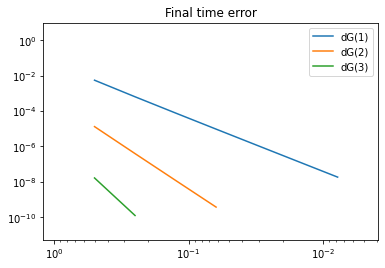

L2-norm error
Slope for dG(1): 2.016279610748216
Slope for dG(2): 3.008088773053004
Slope for dG(3): 4.006058520005028
Slope for dG(4): 5.003189787974026
Slope for dG(5): 5.996920271212073


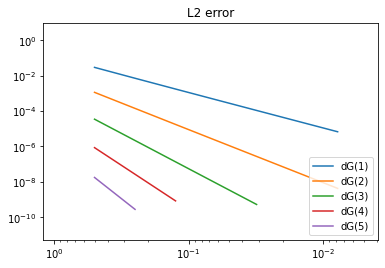

In [7]:
parameters["reorder_dofs_serial"] = False

# define temporal mesh
t0 = 0. # start time
T = 1. # end time
error = {"final": {}, "L2": {}}

for r in range(1,7):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    
    error["final"][r] = []
    error["L2"][r] = []
    
    for n_time in [np.power(2,i) for i in range(1,8)]:
        mesh = IntervalMesh(n_time, t0, T)
        V = FunctionSpace(mesh, 'DG', r)

        # Analytical solution U is used as Dirichlet BC
        U = Expression('exp(x[0])', degree=2*r+3)
        initial_time = CompiledSubDomain("near(x[0], 0) && on_boundary")
        u0 = Constant(1.)
        boundary_marker = MeshFunction("size_t", mesh, 0)
        boundary_marker.set_all(0)
        initial_time.mark(boundary_marker, 1)
        #plot(mesh)
        #plot(boundary_marker)
        #plt.show()
        d0 = Measure('ds', domain=mesh, subdomain_data=boundary_marker, subdomain_id=1)
        
        # Define variational problem
        u = TrialFunction(V)
        v = TestFunction(V)
        a = grad(u)[0]*v*dx - u*v*dx
        # NOTE: FEniCS has weird definitions for '+' and '-' on interior facets (https://fenicsproject.discourse.group/t/integrating-over-an-interior-surface/247/3)
        # SOLUTION: just switch '+' and '-' in mathematical definition of jump terms
        a_jumps = (u('-')-u('+'))*v('-')*dS
        a_initial = u('+')*v('+')*d0
        L = u0*v('+')*d0
        
        #for dof, dof_x in zip(V.dofmap().dofs(), V.tabulate_dof_coordinates().reshape((-1, 1))):
        #    print(dof, ':', dof_x)
            
        # Solve
        u_k = Function(V)
        solve(a + a_jumps + a_initial == L, u_k)

        k = (T - t0) / n_time
        #print(np.array(u_k.vector()))
        error["final"][r].append([k, np.abs(U(1.) - u_k(1.))])
        error["L2"][r].append([k, errornorm(U, u_k, 'L2')])
        
print("Final time error")
plt.title("Final time error")
for r in error["final"].keys():
    k_vals = [e[0] for e in error["final"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["final"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

print("L2-norm error")
plt.title("L2 error")
for r in error["L2"].keys():
    k_vals = [e[0] for e in error["L2"][r] if e[1] > 1e-10]
    err_vals = [e[1] for e in error["L2"][r] if e[1] > 1e-10]
    if len(k_vals) > 1:
        x = k_vals
        y = err_vals
        plt.plot(x, y, label=f"dG({r})")
        plt.axis([1.2, pow(0.5, 8), 5e-12, 1e1])
        print(f"Slope for dG({r}): {(np.log(y[-1]) - np.log(y[0])) / (np.log(x[-1]) - np.log(x[0]))}")
plt.legend(loc="lower right")
plt.xscale("log")
plt.yscale("log")
plt.show()

#print(error["L2"][1])
#print(error["L2"][2])